In [388]:
import pandas as pd
from data_extraction.dummy_data_extractor import extract_dummy_data
from sklearn.metrics import mean_squared_error
from statsforecast import StatsForecast
from prophet import Prophet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import numpy as np

import re
from statsforecast.models import (
    # HoltWinters,
    # CrostonClassic as Croston, 
    # HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    # AutoARIMA
)

In [418]:
master_table = extract_dummy_data("dummy_data")

In [419]:
master_table

,pointID,unit,dqType,dqStart,dqDuration,pointInterval,his
0,@p:dmc_All:r:2ddf07d5-ef59ca94 DMC Building 1 ...,°C,Nulls,2023-03-19 01:10:00+04:00,0 days 23:30:00,0 days 00:05:00,Timestamp val \ 0...


In [420]:
master_table.at[0, "his"]

,Timestamp,val,discharge_Chilled_Water_Cool_Valve_Cmd_AHU_01_B1,discharge_Fan_Vfd_Speed_Sensor_AHU_01_B1
0,2023-03-02 14:05:00+04:00,23.808224,41.660519,61.804546
1,2023-03-02 14:10:00+04:00,23.808224,41.660519,61.669575
2,2023-03-02 14:15:00+04:00,23.808224,41.660519,61.407654
3,2023-03-02 14:20:00+04:00,23.808224,41.660519,61.641323
4,2023-03-02 14:25:00+04:00,23.808224,41.660519,61.659443
...,...,...,...,...
4736,2023-03-19 00:45:00+04:00,22.633480,29.431870,57.147915
4737,2023-03-19 00:50:00+04:00,22.633480,30.548756,57.144928
4738,2023-03-19 00:55:00+04:00,22.633480,30.514156,57.145638
4739,2023-03-19 01:00:00+04:00,22.633480,30.514156,57.148205


In [391]:
# #---------
# # TESTING 
# #---------

# # Testing variables
# row = master_table.iloc[0]
# df = row["his"]
# df.set_index(df.columns[0], inplace=True, drop=True)
# length_of_missing_data = row["dqDuration"]
# data_logging_interval = row["pointInterval"]
# dqStart	= row['dqStart']
# dqDuration = row['dqDuration']


In [392]:
# df

In [393]:
# dqStart

In [394]:
# dqStart = dqStart - length_of_missing_data

In [395]:
# df

In [396]:
# # Drop all NaN
# df = df.dropna()

# # Splitting variables
# y = df[df.columns[0]]  # independent variable
# X = df[[df.columns[1]]]  # dependent variable


# # Filter data for training and testing
# X_train = X[X.index < dqStart]
# y_train = y[X.index < dqStart]
# X_test = X[X.index >= dqStart]
# #y_test = y[X.index >= dqStart]

# # Generate polynomial features
# poly = PolynomialFeatures(degree = 4)
# X_train_poly = poly.fit_transform(X_train)
# X_test_poly = poly.transform(X_test)

# # Train polynomial regression model on the whole dataset
# model = LinearRegression()
# model.fit(X_train_poly, y_train)

# y_pred = model.predict(X_test_poly)

# # Create a new DataFrame with the timestamp as index and y_pred as values
# pred_df = pd.DataFrame(data=y_pred, index=X_test.index, columns=['y_pred'])

In [397]:
# dqStart - length_of_missing_data

In [398]:
# df[df.index >= dqStart][['val']].plot()

In [399]:
# pred_df.plot()

### Models

In [400]:
def seasonal_naive(df, length_of_missing_data, data_logging_interval, dqStart):
    """
    Inputs
    df: df used for training set (from SS)
    length_of_missing_data: interval length of missing data (from SS)
    data_logging_interval: data logging interval - called from the hisDQInterval tag on the point (from SS)

    Output
    forecasts_df: dataframe with predictions for the period missing data. Index names as ts, values column named as "v0
    """
    
    
    # step 1 convert the grid to a dataframe, and set first column as index     ### UNCOMMENT THIS ONLY IF RUNNING THE MODEL DIRECTLY ON SS. THIS IS DONE IN THE ENSEMBLE MODEL SO NO NEED TO HAVE THIS WHEN RUNNING THROUGH ENSEMBLE MODEL
    #df = df.to_dataframe()
    #df.set_index(df.columns[0], inplace=True, drop=True)

    # rename the first column as "target"
    new_column_name = "target"
    df = df.rename(columns={df.columns[0]: new_column_name})

    # keep only the history BEFORE the start of the data quality issue, since this is a statisitcal model not ML model
    df = df[df.index < dqStart]

    # format the df to statsforecast format
    df = df.reset_index()
    df = df.rename(columns={df.columns[0]: 'ds', df.columns[1]: "y"})
    df['unique_id'] = "v0"    

    # number of predictions
    horizon = int(length_of_missing_data/data_logging_interval) + 1 # why -1? because if you do length_of_missing_data/data_logging_interval you will get prediction length that is exclusive of the start ts (start ts is the last ts with actual data before the gap), and inclusive of the end ts (end ts is the first ts with actual data after the gap). +1 to get predictions also for the start and end timestamp. Can remove them later

    # season length
    season_length = int(pd.Timedelta(24, 'h') / data_logging_interval)      

    # frequency
    freq = str(data_logging_interval.total_seconds()/3600)+"h"


    # LIST OF MODELS
    models = [
        SeasonalNaive(season_length=season_length) 
    ]

    # The Model
    sf = StatsForecast( 
        models=models,
        freq=freq, 
        # fallback_model = SeasonalNaive(season_length=season_length),
        n_jobs=-1,
    )

    # Model fitting
    forecasts_df = sf.forecast(df=df[["ds", "y", "unique_id"]], h=horizon, level=[90])  

    # removing the -hi- and -lo- columns
    for col in forecasts_df.columns:
        if re.search("-hi-", col) or re.search("-lo-", col):
            forecasts_df.drop(col, axis=1, inplace=True)
            
    forecasts_df = forecasts_df.rename(columns={"ds": "timestamp", "SeasonalNaive":"seasonalNaive"})

    forecasts_df.set_index("timestamp", inplace=True)

    return forecasts_df

In [401]:
def polynomial_regression(df, length_of_missing_data, data_logging_interval, dqStart):

    """
    Inputs
    df: df used for training set (from SS)
    dqStart: start of the predictions

    Output
    forecasts_df: dataframe with predictions for the period missing data. Index names as ts
    """

    # Drop all NaN
    # df = df.dropna()

    # Splitting variables
    y = df[df.columns[0]]  # independent variable
    X = df[[df.columns[1]]]  # dependent variable

    # Filter data for training and testing
    X_train = X[X.index < dqStart]
    y_train = y[X.index < dqStart]
    X_test = X[X.index >= dqStart]
    #y_test = y[X.index >= dqStart]

    # Generate polynomial features
    poly = PolynomialFeatures(degree = 4)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    # Train polynomial regression model on the whole dataset
    model = LinearRegression()
    model.fit(X_train_poly, y_train)

    y_pred = model.predict(X_test_poly)

    # Create a new DataFrame with the timestamp as index and y_pred as values
    pred_df = pd.DataFrame(data=y_pred, index=X_test.index, columns=['y_pred'])

    return pred_df

In [402]:
def dynamic_optimized_theta(df, length_of_missing_data, data_logging_interval, dqStart):
    """
    Inputs
    df: df used for training set (from SS)
    length_of_missing_data: interval length of missing data (from SS)
    data_logging_interval: data logging interval - called from the hisDQInterval tag on the point (from SS)

    Output
    forecasts_df: dataframe with predictions for the period missing data. Index names as ts, values column named as "v0
    """
    

    # step 1 convert the grid to a dataframe, and set first column as index     ### UNCOMMENT THIS ONLY IF RUNNING THE MODEL DIRECTLY ON SS. THIS IS DONE IN THE ENSEMBLE MODEL SO NO NEED TO HAVE THIS WHEN RUNNING THROUGH ENSEMBLE MODEL
    #df = df.to_dataframe()
    #df.set_index(df.columns[0], inplace=True, drop=True)

    # rename the first column as "target"
    new_column_name = "target"
    df = df.rename(columns={df.columns[0]: new_column_name})

    # keep only the history BEFORE the start of the data quality issue, since this is a statisitcal model not ML model
    df = df[df.index < dqStart]

    # format the df to statsforecast format
    df = df.reset_index()
    df = df.rename(columns={df.columns[0]: 'ds', df.columns[1]: "y"})
    df['unique_id'] = "v0"    

    # number of predictions
    horizon = int(length_of_missing_data/data_logging_interval) + 1 # why -1? because if you do length_of_missing_data/data_logging_interval you will get prediction length that is exclusive of the start ts (start ts is the last ts with actual data before the gap), and inclusive of the end ts (end ts is the first ts with actual data after the gap). +1 to get predictions also for the start and end timestamp. Can remove them later

    # season length
    season_length = int(pd.Timedelta(24, 'h') / data_logging_interval)      

    # frequency
    freq = str(data_logging_interval.total_seconds()/3600)+"h"


    # LIST OF MODELS
    models = [
        DOT(season_length=season_length) 
    ]

    # The Model
    sf = StatsForecast( 
        models=models,
        freq=freq, 
        # fallback_model = SeasonalNaive(season_length=season_length),
        n_jobs=-1,
    )

    # Model fitting
    forecasts_df = sf.forecast(df=df[["ds", "y", "unique_id"]], h=horizon, level=[90])  

    # removing the -hi- and -lo- columns
    for col in forecasts_df.columns:
        if re.search("-hi-", col) or re.search("-lo-", col):
            forecasts_df.drop(col, axis=1, inplace=True)
            
    forecasts_df = forecasts_df.rename(columns={"ds": "timestamp", "DynamicOptimizedTheta":"dynamicOptimizedTheta"})

    forecasts_df.set_index("timestamp", inplace=True)

    return forecasts_df

In [403]:
def facebook_pred(df, length_of_missing_data, data_logging_interval, dqStart):
    df.reset_index(inplace=True)
    df = df.dropna()

    # Keep only the first two columns
    df = df.iloc[:, :2]

    # # renaming columns
    df.columns = ['ds', 'temp']

    # # Remove ' Dubai' from the datetime strings
    # df['ds'] = df['ds'].str.replace(' Dubai', '', regex=False)

    # # Try converting the 'ds' column to datetime format with error handling
    # try:
    #     df['ds'] = pd.to_datetime(df['ds'], format="%Y-%m-%dT%H:%M:%S%z")
    # except ValueError as e:
    #     print(f"Error parsing datetime: {e}")
    #     print("Some datetime strings could not be parsed. Check your data.")
    #     problematic_rows = df[pd.to_datetime(df['ds'], format="%Y-%m-%dT%H:%M:%S%z", errors='coerce').isna()]
    #     print("Problematic rows:")
    #     print(problematic_rows)
    #     return None

    # # Drop rows where datetime parsing failed
    # df = df.dropna(subset=['ds'])

    # # Clean temperature column and convert to numeric
    # df['temp'] = df['temp'].str.replace('°C', '').astype(float)

    # Rename columns for convenience
    # df.columns = ['ds', 'y']

    # Separate data for temperature
    df_temp = df.copy()

    # Ensure 'ds' column is timezone-naive
    # df_temp['ds'] = df_temp['ds'].dt.tz_localize(None)

    # Initialize Prophet models with tuned hyperparameters
    model_temp = Prophet(seasonality_mode='additive',     # Adjust based on data exploration
                         interval_width=0.95,              # Adjust prediction interval if needed
                         changepoint_prior_scale=0.01)    # Tune based on data patterns

    # Fit the models
    model_temp.fit(df_temp)

    # Calculate number of predictions
    samples = int(length_of_missing_data / data_logging_interval) + 1

    # Specify the start date for prediction
    # dq_start = pd.Timestamp(dqStart, tz='Asia/Dubai').tz_localize(None)
    dq_start = dqStart

    # Create future DataFrame starting from dq_start
    future_temp = model_temp.make_future_dataframe(periods=samples, freq='5T')

    # Adjust 'ds' column to start from dq_start
    future_temp['ds'] = dq_start + pd.to_timedelta(range(len(future_temp)), unit='m')

    # Ensure 'ds' column is timezone-naive
    # future_temp['ds'] = future_temp['ds'].dt.tz_localize(None)

    # Predict the future values
    forecast_temp = model_temp.predict(future_temp)

    # Ensure 'ds' column in forecast_temp is timezone-naive
    # forecast_temp['ds'] = forecast_temp['ds'].dt.tz_localize(None)

    # Convert dq_start to timezone-naive
    # dq_start = dq_start.tz_localize(None)

    # Filter predictions to start from dq_start
    predictions = forecast_temp[forecast_temp['ds'] >= dq_start][['ds', 'yhat']]

    return predictions


In [404]:
def kNeighbors_Regressor_Uniform(df, length_of_missing_data, data_logging_interval, dqStart):
    """
    Input
    master_table: main table received from SS

    Output
    df: dataframe with predictions for all rows with missing columns. Index names as ts
    """
    # df = df.at[0,"his"]
    mt = df#.set_index(["ts"])

    # Tag and filter rows with missing
    mt["status"] = mt.isna().any(axis=1)
    mt_predict = mt[mt["status"]==1]
    X_predict = mt_predict.iloc[:,0:1] 

    # Filtered master table
    mt_train = mt.dropna()
    mt_train

    # Load the dataset
    # X = mt.iloc[:,1:-1]  Enable for SS
    # y = mt.iloc[:,0:1]   Enable for SS

    y = mt_train.iloc[:,1:-1]    #Custom due to sample dataset
    X = mt_train.iloc[:,0:1]     #Custom due to sample dataset

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # # Apply KNN regression
    knn_regressor = KNeighborsRegressor(n_neighbors=3,weights="distance")
    knn_regressor.fit(X_train, y_train)
    predictions = knn_regressor.predict(X_test)
    predictions
    # Evaluate the model
    print('Score:', knn_regressor.score(X_test, y_test))

    predict = knn_regressor.predict(X_predict)
    df = pd.DataFrame(data=predict, index=X_predict.index, columns=['y_pred'])
    
    return df

In [405]:
def xgboost_1(df, length_of_missing_data, data_logging_interval, dqStart):
    df.reset_index(inplace=True)
    df = df.dropna()

    # Keep only the first two columns
    df = df.iloc[:, :2]

    # Rename columns
    df.columns = ['ds', 'temp']

    # Remove ' Dubai' from the datetime strings
    df['ds'] = df['ds'].astype(str).str.replace(' Dubai', '', regex=False)

    # Convert the 'ds' column to datetime format
    df['ds'] = pd.to_datetime(df['ds'], format="%Y-%m-%dT%H:%M:%S%z")

    # Drop rows where datetime parsing failed
    df = df.dropna(subset=['ds'])

    # Clean temperature column and convert to numeric
    df['temp'] = df['temp'].str.replace('°C', '').astype(float)

    # Rename columns for convenience
    df.columns = ['ds', 'y']

    # Ensure 'ds' column is timezone-naive
    df['ds'] = df['ds'].dt.tz_localize(None)

    # Extract numerical features from datetime
    df['year'] = df['ds'].dt.year
    df['month'] = df['ds'].dt.month
    df['day'] = df['ds'].dt.day
    df['hour'] = df['ds'].dt.hour
    df['minute'] = df['ds'].dt.minute

    # Create future DataFrame starting from dq_start
    future_periods = int(length_of_missing_data / data_logging_interval) + 1
    dq_start = pd.Timestamp(dqStart).tz_convert('Asia/Dubai').tz_localize(None)
    future_temp = pd.DataFrame()
    future_temp['ds'] = [dq_start + timedelta(minutes=5 * i) for i in range(future_periods)]

    # Extract features for XGBoost
    future_temp['year'] = future_temp['ds'].dt.year
    future_temp['month'] = future_temp['ds'].dt.month
    future_temp['day'] = future_temp['ds'].dt.day
    future_temp['hour'] = future_temp['ds'].dt.hour
    future_temp['minute'] = future_temp['ds'].dt.minute

    # Initialize XGBoost model
    model_temp = xgb.XGBRegressor()

    # Fit the model
    model_temp.fit(df[['year', 'month', 'day', 'hour', 'minute']], df['y'])

    # Predict the future values
    future_temp['yhat'] = model_temp.predict(future_temp[['year', 'month', 'day', 'hour', 'minute']])

    # Filter predictions to start from dq_start
    predictions = future_temp[['ds', 'yhat']]

    # Set 'ds' as the index
    predictions.set_index('ds', inplace=True)

    return predictions

In [406]:
def xgboost_2(df, length_of_missing_data, data_logging_interval, dqStart):
    df.reset_index(inplace=True)
    df = df.dropna()

    # Keep only the first two columns
    df = df.iloc[:, :2]

    # Rename columns
    df.columns = ['ds', 'temp']

    # Remove ' Dubai' from the datetime strings
    df['ds'] = df['ds'].astype(str).str.replace(' Dubai', '', regex=False)

    # Convert the 'ds' column to datetime format
    df['ds'] = pd.to_datetime(df['ds'], format="%Y-%m-%dT%H:%M:%S%z")

    # Drop rows where datetime parsing failed
    df = df.dropna(subset=['ds'])

    # Clean temperature column and convert to numeric
    df['temp'] = df['temp'].str.replace('°C', '').astype(float)

    # Rename columns for convenience
    df.columns = ['ds', 'y']

    # Ensure 'ds' column is timezone-naive
    dq_start = pd.Timestamp(dqStart).tz_convert('Asia/Dubai').tz_localize(None)

    # Extract numerical features from datetime
    df['year'] = df['ds'].dt.year
    df['month'] = df['ds'].dt.month
    df['day'] = df['ds'].dt.day
    df['hour'] = df['ds'].dt.hour
    df['minute'] = df['ds'].dt.minute

    # Create future DataFrame starting from dq_start
    future_periods = int(length_of_missing_data / data_logging_interval) + 1
    dq_start = pd.Timestamp(dqStart, tz='Asia/Dubai').tz_localize(None)
    future_temp = pd.DataFrame()
    future_temp['ds'] = [dq_start + timedelta(minutes=5 * i) for i in range(future_periods)]

    # Extract features for XGBoost
    future_temp['year'] = future_temp['ds'].dt.year
    future_temp['month'] = future_temp['ds'].dt.month
    future_temp['day'] = future_temp['ds'].dt.day
    future_temp['hour'] = future_temp['ds'].dt.hour
    future_temp['minute'] = future_temp['ds'].dt.minute

    ## Initialize XGBoost model with parameters to reduce noise
    model_temp = xgb.XGBRegressor(
        n_estimators=100,   # Number of boosting rounds
        max_depth=3,        # Maximum depth of each tree
        learning_rate=0.1,  # Learning rate
        min_child_weight=1, # Minimum sum of instance weight needed in a child
        subsample=0.8,      # Subsample ratio of the training instances
        colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
        objective='reg:squarederror'  # Objective function for regression task
    )

    # Fit the model
    model_temp.fit(df[['year', 'month', 'day', 'hour', 'minute']], df['y'])

    # Predict the future values
    future_temp['yhat'] = model_temp.predict(future_temp[['year', 'month', 'day', 'hour', 'minute']])

    # Filter predictions to start from dq_start
    predictions = future_temp[['ds', 'yhat']]

    # Set 'ds' as the index
    predictions.set_index('ds', inplace=True)

    return predictions

In [407]:
# df[(df.index >= dqStart-pd.Timedelta("10day")) & (df.index <= dqStart-pd.Timedelta("9day"))]

In [408]:
def ensemble_model(python_master_table):
    """
    Function to run all models, and return the one with lowest RMSE.
    Models running through the ensemble model will have input DataFrame (AKA the "his" column on master_table) 
    with timestamp as index, target variable as first column, feature variables as the rest of the columns.

    Make sure the output predictions of all models are INCLUSIVE of both the "start ts" and "end ts" (AKA
    last ts with real data before gap, and first ts with real data after gap) 

    Make sure to follow camelCase for DataFrame column naming for compatibility with SS
    """

    # dictionary to save predictions for each point
    scores_df_dict = {
    "pointID": [],
    "predictions": [],
    "rmse": [],
    "modelName": []
    }

    # Create a DataFrame from the dictionary
    scores_df = pd.DataFrame(scores_df_dict)

    for i, row in python_master_table.iterrows():

        #-----------------
        # INPUTS TO MODELS
        #-----------------

        pointID = row["pointID"]
        df = row["his"]#.to_dataframe()                           #### IMPORTANT : UNCOMMENT THIS ON SS
        df.set_index(df.columns[0], inplace=True, drop=True)
        length_of_missing_data = row["dqDuration"]
        data_logging_interval = row["pointInterval"]
        dqStart = row["dqStart"]

        #----------------------------
        # Dict of Data Quality Models                              ############# ADD NEW MODELS HERE 
        #----------------------------

        # UNIVARIATE Models
        dq_models_univariate = {
            "Seasonal Naive" : seasonal_naive,
            "Dynamic Optimized Theta": dynamic_optimized_theta
        }

        # MULTIVARIATE Models using all features to predict target
        dq_models_multivariate = {
            "Random Forest Regressor" : random_Forest_Regressor,
            "KNN Regressor Uniform ": kNeighbors_Regressor_Uniform,
            "XGBoost 1": xgboost_1,
            "XGboost 2": xgboost_2,
            "XGboost 3": xgboost_3
        }

        # MULTIVARIATE Models using one feature at a time
        dq_models_multivariate_1feature = {
            "Polynomial Regression" : polynomial_regression,
        }

        # if len(df.columns) > 1 ===> use multivariate models dictionary 

        for model_name, model in dq_models.items():
            
            #------------------------
            # ** Calculating RMSE **
            #------------------------

            # number of predictions needed
            horizon = int(length_of_missing_data/data_logging_interval) +1 # why +1? because if you do length_of_missing_data/data_logging_interval you will get prediction length that is exclusive of the start ts (start ts is the last ts with actual data before the gap), and inclusive of the end ts (end ts is the first ts with actual data after the gap). +1 to get predictions INCLUSIVE of BOTH start and end ts

            # training set size (relative to the horizon/prediction size)
            training_set_size = horizon * 10

            # training / testing set to evaluate the model (relative to horizon of prediction)
            train_data = df.iloc[-1*int(training_set_size):-1*int(horizon)]
            test_data = df.iloc[-1*int(horizon):]

            # the prediction. USED ONLY TO EVALUATE RMSE
            predictions_for_rmse = model(train_data, length_of_missing_data, data_logging_interval, dqStart)
            rmse_score = mean_squared_error(test_data[test_data.columns[0]].to_numpy(), predictions_for_rmse[predictions_for_rmse.columns[0]].to_numpy(), squared=False)

            #------------------
            # ** Predictions **
            #------------------

            # the predictions. USED FOR DATA CLEANING (uses all the data as training)
            predictions_for_data_quality = model(df, length_of_missing_data, data_logging_interval, dqStart)

            # keep only timestamps for null periods (rows where there are null values on SS)
            start = row['dqStart']
            duration = row['dqDuration']
            interval = row['pointInterval']
            timestamps = pd.date_range(start=start, end=start+duration, freq=interval)[1:-1] # clipping the first and last timestamps, as they already exist with actual data on SS

            predictions_for_data_quality = predictions_for_data_quality[predictions_for_data_quality.index.isin(timestamps)]

            # reset index to make the ts a column instead of index. SS doesnt show the index of a DF
            predictions_for_data_quality = predictions_for_data_quality.reset_index()

            # rename the ts and predictions column to "ts" and "predictions", to have similar naming for all ouutputs of models (makes it easier as well when using the dcInsert function on SS.)
            predictions_for_data_quality.columns = ["ts", "predictions"]

            # append data to the scores DF
            row_to_append = {'pointID': pointID, 'predictions': predictions_for_data_quality, 
                            "rmse": rmse_score, "modelName": model_name, 
                            "identifier": 
                                str(row["pointID"])
                                +str(row["dqStart"])
                                +str(row["dqDuration"])
                                +str(row["dqType"])}
            
            scores_df = pd.concat([scores_df, pd.DataFrame([row_to_append])], ignore_index=True)

            # return predictions with least RMSE for each point/dq issue
            idx = scores_df.groupby('identifier')['rmse'].idxmin()
            scores_df = scores_df.loc[idx].reset_index(drop=True)
            
    return scores_df    

In [409]:
# WRITING THE mulitvariate models one at a time loop

master_table
i = 0
row = master_table.iloc[0]


# dictionary to save predictions for each point
scores_df_dict = {
"pointID": [],
"predictions": [],
"rmse": [],
"modelName": []
}
# Create a DataFrame from the dictionary
scores_df = pd.DataFrame(scores_df_dict)

#-----------------
# INPUTS TO MODELS
#-----------------

pointID = row["pointID"]
df = row["his"]#.to_dataframe()                           #### IMPORTANT : UNCOMMENT THIS ON SS
df.set_index(df.columns[0], inplace=True, drop=True)

# creating a fake dqStart and fake length of missing data for testing
df.loc[df.index >= '2023-03-17', 'val'] = np.nan
dqStart = df[df.val.isna()].iloc[0].name
length_of_missing_data = df[df.val.isna()].iloc[-1].name - df[df.val.isna()].iloc[0].name
# dqStart = row["dqStart"]
# length_of_missing_data = row["dqDuration"]

data_logging_interval = row["pointInterval"]


#----------------------------
# Dict of Data Quality Models                              ############# ADD NEW MODELS HERE 
#----------------------------


# UNIVARIATE Models
dq_models_univariate = {
    "Seasonal Naive" : seasonal_naive,
    "Dynamic Optimized Theta": dynamic_optimized_theta
}

# MULTIVARIATE Models using one feature at a time
dq_models_multivariate_1feature = {
    "Polynomial Regression" : polynomial_regression,
}

# # MULTIVARIATE Models using all features to predict target
# dq_models_multivariate = {
#     "Random Forest Regressor" : random_Forest_Regressor,
#     "KNN Regressor Uniform ": kNeighbors_Regressor_Uniform,
#     "XGBoost 1": xgboost_1,
#     "XGboost 2": xgboost_2,
#     "XGboost 3": xgboost_3
# }


# only run multivariate if there are features available to use from the master table
if len(df.columns)>1:
    multivariate = True


#####
# for model_name, model in dq_models_multivariate_1feature.items():

# variables for testing
model_name = "Polynomial Regression"
model = polynomial_regression

#------------------------
# ** Calculating RMSE **
#------------------------

# number of predictions needed
horizon = int(length_of_missing_data/data_logging_interval) +1 # why +1? because if you do length_of_missing_data/data_logging_interval you will get prediction length that is exclusive of the start ts (start ts is the last ts with actual data before the gap), and inclusive of the end ts (end ts is the first ts with actual data after the gap). +1 to get predictions INCLUSIVE of BOTH start and end ts

# training set size (relative to the horizon/prediction size)
training_set_size = horizon * 10

# training / testing set to evaluate the model (relative to horizon of prediction)
train_data = df.iloc[-1*int(training_set_size):-1*int(horizon)]
test_data = df.iloc[-1*int(horizon):]


In [410]:
train_data



,DMC Building 1 Data Quality Tests Dup of AHU_04_B1 Return Air Temp,DMC Building 1 Data Quality Tests New-Point,val
ts,,,


In [411]:
df

,DMC Building 1 Data Quality Tests Dup of AHU_04_B1 Return Air Temp,DMC Building 1 Data Quality Tests New-Point,val
ts,,,
2023-02-24 18:45:00+04:00,24.420517,NaN,NaN
2023-02-24 18:50:00+04:00,24.420517,NaN,NaN
2023-02-24 18:55:00+04:00,24.420517,NaN,NaN
2023-02-24 19:00:00+04:00,24.345844,NaN,NaN
2023-02-24 19:05:00+04:00,24.271170,NaN,NaN
...,...,...,...
2023-03-12 00:40:00+04:00,24.119339,31.959213,NaN
2023-03-12 00:45:00+04:00,24.119339,33.179718,NaN
2023-03-12 00:50:00+04:00,24.119339,35.324806,NaN


In [412]:

# the prediction. USED ONLY TO EVALUATE RMSE
# predictions_for_rmse = model(df, length_of_missing_data, data_logging_interval, dqStart)
# rmse_score = mean_squared_error(test_data[test_data.columns[0]].to_numpy(), predictions_for_rmse[predictions_for_rmse.columns[0]].to_numpy(), squared=False)



In [413]:
df

,DMC Building 1 Data Quality Tests Dup of AHU_04_B1 Return Air Temp,DMC Building 1 Data Quality Tests New-Point,val
ts,,,
2023-02-24 18:45:00+04:00,24.420517,NaN,NaN
2023-02-24 18:50:00+04:00,24.420517,NaN,NaN
2023-02-24 18:55:00+04:00,24.420517,NaN,NaN
2023-02-24 19:00:00+04:00,24.345844,NaN,NaN
2023-02-24 19:05:00+04:00,24.271170,NaN,NaN
...,...,...,...
2023-03-12 00:40:00+04:00,24.119339,31.959213,NaN
2023-03-12 00:45:00+04:00,24.119339,33.179718,NaN
2023-03-12 00:50:00+04:00,24.119339,35.324806,NaN


In [415]:
master_table

,pointID,unit,dqType,dqStart,dqDuration,pointInterval,his
0,@p:dmc_All:r:2ddf07d5-ef59ca94 DMC Building 1 ...,°C,Nulls,2023-03-12 01:05:00+04:00,1 days 11:10:00,0 days 00:05:00,DMC Building 1 Data...
1,@p:dmc_All:r:2ddf07d5-ef59ca94 DMC Building 1 ...,°C,Nulls,2023-03-19 01:10:00+04:00,0 days 23:30:00,0 days 00:05:00,DMC Building 1 Data...


In [421]:
df = master_table.at[0, "his"]#.to_dataframe()

In [422]:
df.set_index(df.columns[0], inplace=True, drop=True)

<Axes: xlabel='Timestamp'>

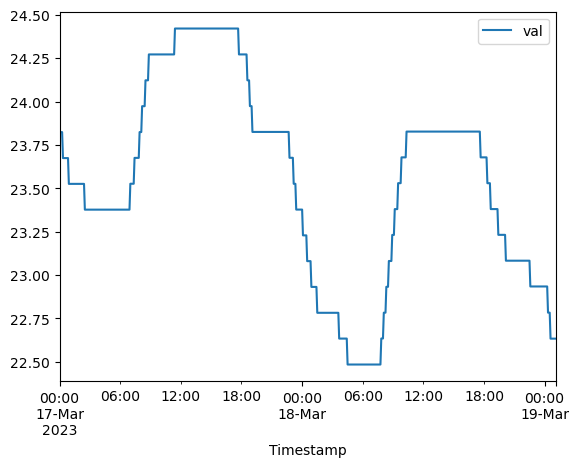

In [426]:
df[df.index >= '2023-03-17'][["val"]].plot()

<Axes: xlabel='Timestamp'>

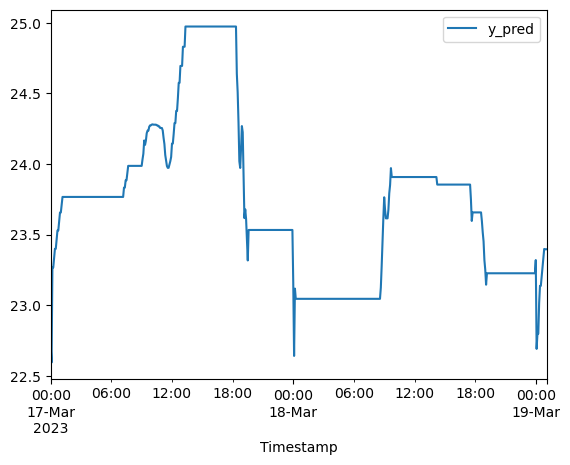

In [344]:
predictions_for_rmse.plot()

In [ ]:
# for model_name, model in dq_models.items():

#------------------
# ** Predictions **
#------------------

# the predictions. USED FOR DATA CLEANING (uses all the data as training)
predictions_for_data_quality = model(df, length_of_missing_data, data_logging_interval, dqStart)

# keep only timestamps for null periods (rows where there are null values on SS)
start = row['dqStart']
duration = row['dqDuration']
interval = row['pointInterval']
timestamps = pd.date_range(start=start, end=start+duration, freq=interval)[1:-1] # clipping the first and last timestamps, as they already exist with actual data on SS

predictions_for_data_quality = predictions_for_data_quality[predictions_for_data_quality.index.isin(timestamps)]

# reset index to make the ts a column instead of index. SS doesnt show the index of a DF
predictions_for_data_quality = predictions_for_data_quality.reset_index()

# rename the ts and predictions column to "ts" and "predictions", to have similar naming for all ouutputs of models (makes it easier as well when using the dcInsert function on SS.)
predictions_for_data_quality.columns = ["ts", "predictions"]

# append data to the scores DF
row_to_append = {'pointID': pointID, 'predictions': predictions_for_data_quality, 
                "rmse": rmse_score, "modelName": model_name, 
                "identifier": 
                    str(row["pointID"])
                    +str(row["dqStart"])
                    +str(row["dqDuration"])
                    +str(row["dqType"])}

scores_df = pd.concat([scores_df, pd.DataFrame([row_to_append])], ignore_index=True)

# return predictions with least RMSE for each point/dq issue
idx = scores_df.groupby('identifier')['rmse'].idxmin()
scores_df = scores_df.loc[idx].reset_index(drop=True)
    